In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import yaml
from sklearn.preprocessing import StandardScaler, PolynomialFeatures
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

In [2]:
# Load settings from config.yaml
with open("config.yaml", 'r') as file:
    config = yaml.safe_load(file)

In [3]:
all_parameters_with_IVS_data_path = config['calculate_final_IVS']['data']['calculated_daily_IVS_data_path']

### Test using Polynomial Regression

C:\Users\LENOVO\AppData\Local\Temp\ipykernel_1536\3577886239.py:53: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_data['Predicted_IVS'] = y_pred_poly


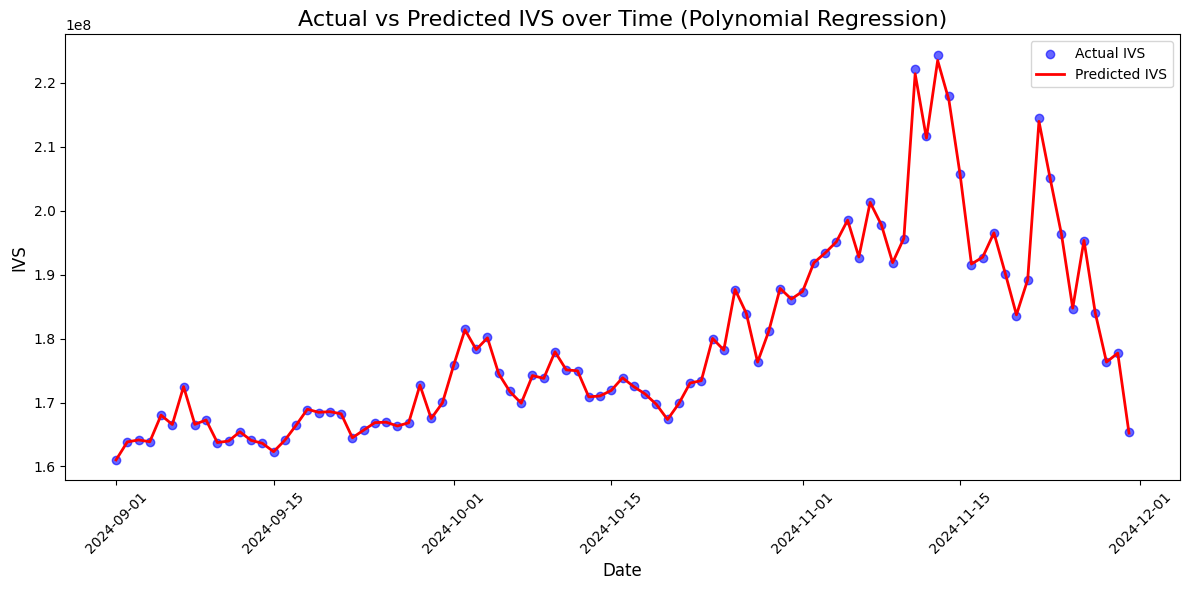

Coefficients of the Polynomial model: [ 0.00000000e+00  8.64550585e+06 -8.99514598e+04  1.16477473e+07
  9.65926348e+03  1.39380273e+04  7.42728018e+05 -3.48371317e+04
  2.60543933e+04  6.66813079e+05]
Mean Absolute Error (MAE) for Polynomial Regression: 85156.9750
Mean Squared Error (MSE) for Polynomial Regression: 28152738743.0953
Root Mean Squared Error (RMSE) for Polynomial Regression: 167787.7789
R² Score for Polynomial Regression: 0.9999


In [4]:
# Step 1: Prepare the data
data = pd.read_csv(all_parameters_with_IVS_data_path, parse_dates=['Date'])

data = data[['Date', 'Votable Supply',
              'Circulating Supply', 'F', 'IVS']]

# Split the data into training and testing based on the date range
train_data = data[(data['Date'] >= "2023-12-04") & (data['Date'] <= "2024-08-31")]
test_data = data[(data['Date'] >= "2024-09-01") & (data['Date'] <= "2024-11-30")]

# Separate features and target variable
X_train = train_data.drop(columns=["Date", "IVS"])
y_train = train_data["IVS"]

X_test = test_data.drop(columns=["Date", "IVS"])
y_test = test_data["IVS"]

# Step 2: Scale the OP_Token_Balance column only
scaler = StandardScaler()

# Scale OP_Token_Balance for both training and testing
X_train_scaled = X_train.copy()
X_test_scaled = X_test.copy()

X_train_scaled['Votable Supply'] = scaler.fit_transform(X_train[['Votable Supply']])
X_test_scaled['Votable Supply'] = scaler.transform(X_test[['Votable Supply']])

X_train_scaled['Circulating Supply'] = scaler.fit_transform(X_train[['Circulating Supply']])
X_test_scaled['Circulating Supply'] = scaler.transform(X_test[['Circulating Supply']])

X_train_scaled['F'] = scaler.fit_transform(X_train[['F']])
X_test_scaled['F'] = scaler.transform(X_test[['F']])

# Step 3: Apply Polynomial Transformation (you can adjust the degree)
poly = PolynomialFeatures(degree = 2)

# Transform features into polynomial features
X_train_poly = poly.fit_transform(X_train_scaled)
X_test_poly = poly.transform(X_test_scaled)

# Step 4: Train the Polynomial Regression model
# Initialize the model
poly_lr_model = LinearRegression()

# Train the model on the polynomial transformed training data
poly_lr_model.fit(X_train_poly, y_train)

# Step 5: Evaluate the model
# Predict on the transformed test data
y_pred_poly = poly_lr_model.predict(X_test_poly)

# Add predictions to the test data for visualization
test_data['Predicted_IVS'] = y_pred_poly

# Sort the test data by the 'Date' column
test_data = test_data.sort_values(by='Date')

# Plotting for Polynomial Regression
plt.figure(figsize=(12, 6))
plt.scatter(test_data['Date'], test_data['IVS'], color='blue', label='Actual IVS', alpha=0.6)
plt.plot(test_data['Date'], test_data['Predicted_IVS'], color='red', label='Predicted IVS', linewidth=2)
plt.title('Actual vs Predicted IVS over Time (Polynomial Regression)', fontsize=16)
plt.xlabel('Date', fontsize=12)
plt.ylabel('IVS', fontsize=12)
plt.legend()
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

# Coefficients of the polynomial model
print("Coefficients of the Polynomial model:", poly_lr_model.coef_)

# Calculate error metrics
mae_poly = mean_absolute_error(y_test, y_pred_poly)
mse_poly = mean_squared_error(y_test, y_pred_poly)
rmse_poly = mse_poly ** 0.5
r2_poly = r2_score(y_test, y_pred_poly)

# Display results
print(f"Mean Absolute Error (MAE) for Polynomial Regression: {mae_poly:.4f}")
print(f"Mean Squared Error (MSE) for Polynomial Regression: {mse_poly:.4f}")
print(f"Root Mean Squared Error (RMSE) for Polynomial Regression: {rmse_poly:.4f}")
print(f"R² Score for Polynomial Regression: {r2_poly:.4f}")


### Predict future IVS

C:\Users\LENOVO\AppData\Local\Temp\ipykernel_1536\2162189766.py:47: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  future_data['IVS'] = poly_lr_model.predict(X_future_poly)


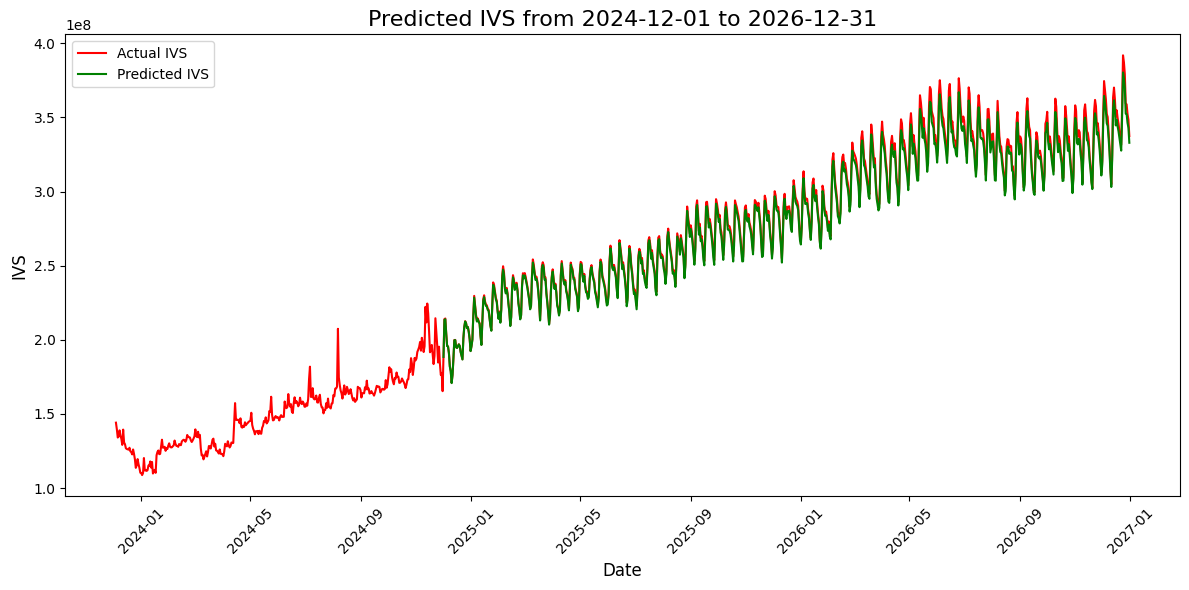

In [5]:
# Load the complete dataset
data = pd.read_csv(all_parameters_with_IVS_data_path, parse_dates=['Date'])

# Select relevant columns
data = data[['Date', 'Votable Supply',
             'Circulating Supply', 'F', 'IVS']]

# Convert 'Date' column to datetime
data['Date'] = pd.to_datetime(data['Date'])

# Split the data
train_data = data[(data['Date'] >= "2023-12-04") & (data['Date'] <= "2024-11-30")]
future_data = data[(data['Date'] >= "2024-12-01") & (data['Date'] <= "2026-12-31")]

# Separate features and target
X_train = train_data.drop(columns=["Date", "IVS"])
y_train = train_data["IVS"]

X_future = future_data.drop(columns=["Date", "IVS"])  

# Standardization using scalers trained on the training data
scaler_votable = StandardScaler()
scaler_circulating = StandardScaler()
scaler_f = StandardScaler()

X_train_scaled = X_train.copy()
X_train_scaled['Votable Supply'] = scaler_votable.fit_transform(X_train[['Votable Supply']])
X_train_scaled['Circulating Supply'] = scaler_circulating.fit_transform(X_train[['Circulating Supply']])
X_train_scaled['F'] = scaler_f.fit_transform(X_train[['F']])

# Apply the same scalers to future data
X_future_scaled = X_future.copy()
X_future_scaled['Votable Supply'] = scaler_votable.transform(X_future[['Votable Supply']])
X_future_scaled['Circulating Supply'] = scaler_circulating.transform(X_future[['Circulating Supply']])
X_future_scaled['F'] = scaler_f.transform(X_future[['F']])

# Apply Polynomial Features Transformation
poly = PolynomialFeatures(degree=2)
X_train_poly = poly.fit_transform(X_train_scaled)
X_future_poly = poly.transform(X_future_scaled)

# Train Polynomial Regression Model
poly_lr_model = LinearRegression()
poly_lr_model.fit(X_train_poly, y_train)

# Predict IVS for the future period
future_data['IVS'] = poly_lr_model.predict(X_future_poly)

# Save Predictions to CSV
predicted_IVS_data_path = config['predicted_IVS']['data']['predicted_daily_IVS_data_path']
future_data.to_csv(predicted_IVS_data_path, index=False)

# Plot Predictions
plt.figure(figsize=(12, 6))
plt.plot(data['Date'], data['IVS'], color='red', label='Actual IVS')
plt.plot(future_data['Date'], future_data['IVS'], color='green', label='Predicted IVS')
plt.title('Predicted IVS from 2024-12-01 to 2026-12-31', fontsize=16)
plt.xlabel('Date', fontsize=12)
plt.ylabel('IVS', fontsize=12)
plt.legend()
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


### Plot the predicion results

In [6]:
data = pd.read_csv(all_parameters_with_IVS_data_path, parse_dates=['Date'])
data = data[['Date', 'Votable Supply', 'IVS']]

pred_data = pd.read_csv(predicted_IVS_data_path, parse_dates=['Date'])
pred_data = pred_data[['Date', 'Votable Supply', 'IVS']]

In [7]:
combined_data = pd.concat([data, pred_data])

In [8]:
# Resample by month and take the mean
monthly_data = pred_data.resample('M', on='Date')[['Votable Supply', 'IVS']].mean()
monthly_IVS_data_path = config['predicted_IVS']['data']['predicted_monthly_IVS_data_path']
monthly_data.to_csv(monthly_IVS_data_path, index=True)

C:\Users\LENOVO\AppData\Local\Temp\ipykernel_1536\3325841259.py:2: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  monthly_data = pred_data.resample('M', on='Date')[['Votable Supply', 'IVS']].mean()


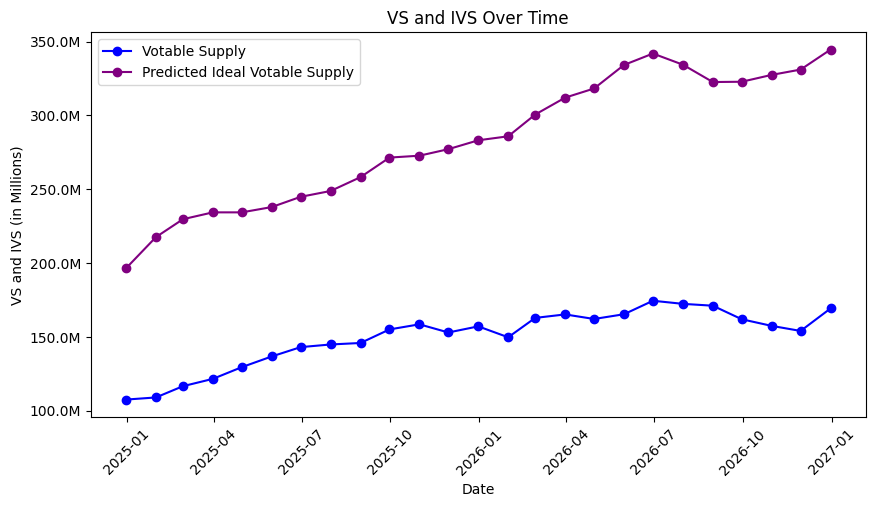

In [9]:
# Create the figure and axis
fig, ax = plt.subplots(figsize=(10, 5))

# Plot the data
ax.plot(monthly_data.index, monthly_data["Votable Supply"], marker='o', color='blue', label="Votable Supply")
ax.plot(monthly_data.index, monthly_data["IVS"], marker='o', color='purple', label="Predicted Ideal Votable Supply")

# Format y-axis in Millions
ax.yaxis.set_major_formatter(ticker.FuncFormatter(lambda x, pos: f'{x / 1e6:.1f}M'))

# Labels and title
ax.set_xlabel("Date")
ax.set_ylabel("VS and IVS (in Millions)")
ax.set_title("VS and IVS Over Time")
ax.legend()

# Rotate x-axis labels for better readability
plt.xticks(rotation=45)

# Show the plot
plt.show()

### Plot VS+FVS, Calculated_IVS, Predicted_IVS

#### Monthly Graph

In [10]:
calculated_monthly_IVS_data_path = config['calculate_final_IVS']['data']['calculated_monthly_IVS_data_path']
predicted_monthly_IVS_data_path = config['predicted_IVS']['data']['predicted_monthly_IVS_data_path']
all_parameters_data_path = config['merge_and_scale_data']['data']['all_parameters_merged_data_path']

In [11]:
calc_data = pd.read_csv(calculated_monthly_IVS_data_path, parse_dates=['Date'])
pred_data = pd.read_csv(monthly_IVS_data_path, parse_dates=['Date'])
data = pd.read_csv(all_parameters_data_path, parse_dates=['Date'])

In [12]:
monthly_VS = data.resample('M', on='Date')[['Votable Supply']].mean()

C:\Users\LENOVO\AppData\Local\Temp\ipykernel_1536\4245519757.py:1: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  monthly_VS = data.resample('M', on='Date')[['Votable Supply']].mean()


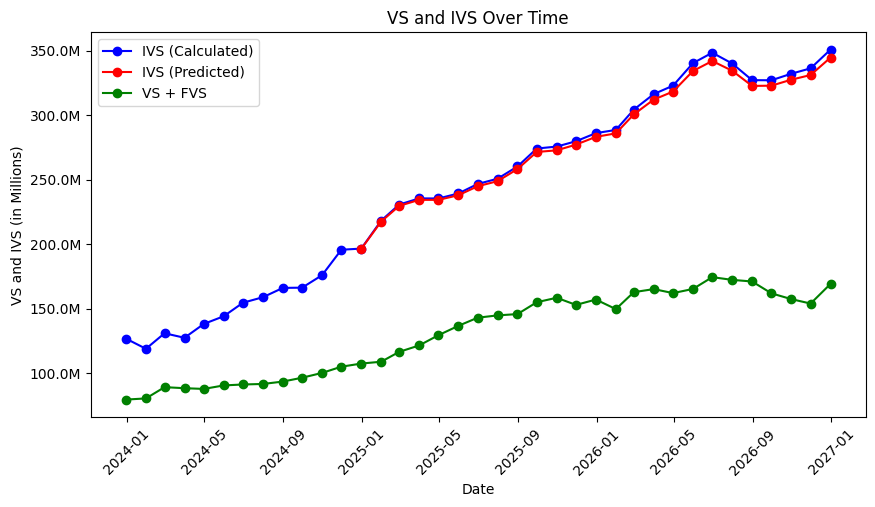

In [13]:
# Create the figure and axis
fig, ax = plt.subplots(figsize=(10, 5))

# Plot the data
ax.plot(calc_data['Date'], calc_data["IVS"], marker='o', color='blue', label="IVS (Calculated)")
ax.plot(pred_data['Date'], pred_data["IVS"], marker='o', color='red', label="IVS (Predicted)")
ax.plot(monthly_VS.index, monthly_VS["Votable Supply"], marker='o', color='green', label="VS + FVS")
ax.plot()

# Format y-axis in Millions
ax.yaxis.set_major_formatter(ticker.FuncFormatter(lambda x, pos: f'{x / 1e6:.1f}M'))

# Labels and title
ax.set_xlabel("Date")
ax.set_ylabel("VS and IVS (in Millions)")
ax.set_title("VS and IVS Over Time")
ax.legend()

# Rotate x-axis labels for better readability
plt.xticks(rotation=45)

# Show the plot
plt.show()